# 端云协同移动部署

本实验使用[MindSpore Vision](https://mindspore.cn/vision/docs/zh-CN/r0.1/index.html)中的`Resnet50`网络微调的方法来开发一个AI应用（花分类），并将训练好的网络模型部署到Android手机上，执行推理和部署功能。

## 1. 数据准备与加载

### 1.1 下载数据集

首先需要下载本案例所用到的[花分类数据集](https://git.openi.org.cn/attachments/dd663765-98f8-473d-92ff-ca6a9ef3b5c0?type=0)，该数据集有雏菊（daisy ）、蒲公英（dandelion）、玫瑰花（roses）、向日葵(sunflowers)、郁金香（tulips）五个类别，每个类有大约250张训练图像、40张验证图像和1张推理图像。

具体数据集如下所示：

![datset-flowers](https://typora-stzz.oss-cn-beijing.aliyuncs.com/output.png)

使用MindSpore Vision中的`DownLoad`接口下载并解压数据集到指定路径下，示例代码如下所示：

In [1]:
import os
import requests
import time
import zipfile

# 自动下载并解压数据集到指定文件夹内
def download_and_unzip(url, path):
    if not os.path.exists(path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(path)
    file_path = os.path.join(path, 'case11Fiveflowers.zip')
    start = time.time() #下载开始时间
    user, password = 'tyx_neu', 'Sportlab307'
    resp = requests.get(url, auth=(user, password), stream=True)      #把下载地址发送给requests模块
    size = 0    #初始化已下载大小
    chunk_size = 1024  # 每次下载的数据大小
    content_size = int(resp.headers['content-length'])  # 下载文件总大小
    try:
        if resp.status_code == 200:   #判断是否响应成功
            print('Start download,[File size]:{size:.2f} MB'.format(size=content_size/chunk_size/1024))   #开始下载，显示下载文件大小
            with open(file_path, 'wb') as file:   #显示进度条
                for data in resp.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    size += len(data)
                    print('\r'+'[下载进度]:%s%.2f%%' % ('>'*int(size*50/content_size), float(size/content_size*100)), end=' ')
        end = time.time()   #下载结束时间
        print('\n'+'Download completed!,times: %.2f秒' % (end - start))  #输出下载用时时间
    except ValueError:
        print('Error!')
    unzip_file_path = os.path.join(path, 'case11Fiveflowers')
    if not os.path.exists(unzip_file_path):   # 看是否有该文件夹，没有则创建文件夹
        os.mkdir(unzip_file_path)
    zip_file = zipfile.ZipFile(file_path)
    zip_list = zip_file.namelist()  # 压缩文件清单，可以直接看到压缩包内的各个文件的明细
    for f in zip_list:  # 遍历这些文件，逐个解压出来，
        zip_file.extract(f, unzip_file_path)
    zip_file.close()
    print('Successfully unzip download dataset from website!')

#下载地址
url = 'https://openi.pcl.ac.cn/attachments/0405d976-18a7-46b1-81d2-9ccad3b722ae?type=1'
download_and_unzip(url, os.path.join(os.getcwd(), 'dataset'))

Start download,[File size]:112.58 MB
[下载进度]:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>100.00% 
Download completed!,times: 108.67秒
Successfully unzip download dataset from website!


数据集的目录结构如下所示：

```Text
datasets
└── FiveFlowers
    ├── infer
    │   ├── daisy.jpg
    │   ├── dandelion.jpg
    │   ├── roses.jpg
    │   ├── sunflowers.jpg
    │   └── tulips.jpg
    ├── train
    │   ├── daisy
    │   ├── dandelion
    │   ├── roses
    │   ├── sunflowers
    │   └── tulips
    └── val
        ├── daisy
        ├── dandelion
        ├── roses
        ├── sunflowers
        └── tulips
```

### 1.2 加载数据集

定义 `create_dataset`函数加载花数据集，对数据集进行图像增强操作并设置数据集batch_size大小。

In [2]:
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

def create_dataset(path, batch_size=10, train=True, image_size=224):
    dataset = ds.ImageFolderDataset(path,
                                    num_parallel_workers=8,
                                    class_indexing={"daisy": 0, "dandelion": 1, "roses": 2, "sunflowers": 3, "tulips": 4})

    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            vision.c_transforms.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            vision.c_transforms.RandomHorizontalFlip(prob=0.5),
            vision.c_transforms.Normalize(mean=mean, std=std),
            vision.c_transforms.HWC2CHW()
        ]
    else:
        trans = [
            vision.c_transforms.Decode(),
            vision.c_transforms.Resize(256),
            vision.c_transforms.CenterCrop(image_size),
            vision.c_transforms.Normalize(mean=mean, std=std),
            vision.c_transforms.HWC2CHW()
        ]

    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

加载训练数据集和验证数据集用于后续的模型训练和验证。

In [3]:
# 加载训练数据集
train_path = "./dataset/case11Fiveflowers/case11/FiveFlowers/train"
dataset_train = create_dataset(train_path, train=True)

# 加载验证数据集
val_path = "./dataset/case11Fiveflowers/case11/FiveFlowers/val"
dataset_val = create_dataset(val_path, train=False)

## 2. 模型训练

本案例使用Resnet50预训练模型在5种花卉的分类数据集上对模型进行微调，并将微调训练好的CKPT模型文件转换为MINDIR格式，用于后续手机侧的部署。

### 2.1 Resnet模型原理

Resnet是2015年由何凯明提出的一个分类网络模型,并在`ImageNet Classification`、`ImageNet Detection`、`ImageNet Localization`、`COCO Detection`、`COCO Segmentation`这五个主要赛道中都获得第一名，残差结构如下图所示。

<div align="center">
<img src="./images/残差结构.png" width="50%" height="50%">
</div>

图中输入`x`，输出为`H(x)=F(x)+x`，此公式可以直观地理解为输出来自两部分，一部分源于输入`x`本身，一部分源于将输入进行一系列非线性变换后的结果`F(x)`。需要网络学习的部分就是`F(x)`，即**只需要学习输入输出差别的那一部分**，简化了学习的目标。

> [详细内容可参见Resnet论文](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

### 2.2 下载预训练模型

下载案例所需的[resnet50预训练模型的ckpt文件](https://download.mindspore.cn/vision/classification/resnet50_224.ckpt)，预训练模型的宽度系数$\alpha= 1.0$，输入图像大小为(224, 224), 将下载的预训练模型保存在当前目录下。使用MindSpore Vision中的`DownLoad`下载预训练模型文件到当前目录下，示例代码如下所示：

In [4]:
from mindvision.dataset import DownLoad

models_url = "https://download.mindspore.cn/vision/classification/resnet50_224.ckpt"

dl = DownLoad()
# 下载预训练模型文件
dl.download_url(models_url, "./checkpoints")

102459392B [01:10, 1447682.63B/s]                                


### 2.3 Resnet50模型微调

本章使用Resnet50的预训练模型进行微调，通过删除Resnet50预训练模型中最后一个用于分类的1x1的卷积层的参数，使用花分类数据集对模型进行重新训练以更新模型参数。

In [5]:
import mindspore.nn as nn
import mindspore as ms
from mindvision.classification.models import resnet50
from mindvision.engine.loss import CrossEntropySmooth

# 创建模型,其中目标分类数为5，图像输入大小为(224,224)
network = resnet50(num_classes=5)

# 模型参数存入到param_dict
param_dict = ms.load_checkpoint("./checkpoints/resnet50_224.ckpt")

# 获取resnet50网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.get_parameters()]

# 删除预训练模型的最后一个卷积层
def filter_ckpt_parameter(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break

filter_ckpt_parameter(param_dict, filter_list)

# 加载预训练模型参数作为网络初始化权重
ms.load_param_into_net(network, param_dict)

# 定义优化器
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)
# network_opt = nn.Adam(params=network.trainable_params(), learning_rate=0.001)


# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=5)
# network_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = ms.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

[WARNING] ME(29144:10068,MainProcess):2023-01-06-16:04:27.943.486 [mindspore\train\serialization.py:648] For 'load_param_into_net', 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(29144:10068,MainProcess):2023-01-06-16:04:27.944.455 [mindspore\train\serialization.py:650] head.dense.weight is not loaded.
[WARNING] ME(29144:10068,MainProcess):2023-01-06-16:04:27.945.455 [mindspore\train\serialization.py:650] head.dense.bias is not loaded.


Delete parameter from checkpoint:  head.dense.weight
Delete parameter from checkpoint:  head.dense.bias


> 上述WARNING是由于模型微调需要删除预训练模型的最后一个卷积层的参数，所以加载预训练模型会显示`head.classifier`参数未加载，`head.classifier`参数会使用创建模型时的初始化值。

### 2.4 微调前可视化预测模型

定义 `visualize_model` 函数，使用未进行微调的**预训练模型**进行预测，并将预测结果可视化。

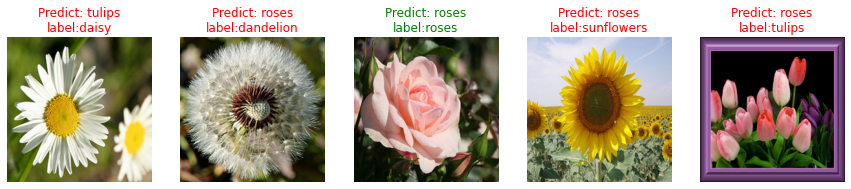

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mindvision.classification.models import resnet50
import mindspore as ms

def visualize_model(image_path, label, model=model):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 模型预测
    pre = model.predict(ms.Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "daisy", 1: "dandelion", 2: "roses", 3: "sunflowers", 4: "tulips"}
    color = 'green' if class_name[result] == label else 'red'

    plt.title(f"Predict: {class_name[result]}\nlabel:{label}", color=color)
    plt.axis("off")
    return result

image1 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/daisy.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 5, 1)
visualize_model(image1, "daisy")

image2 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/dandelion.jpg"
plt.subplot(1, 5, 2)
visualize_model(image2, "dandelion")

image3 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/roses.jpg"
plt.subplot(1, 5, 3)
visualize_model(image3, "roses")

image4 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/sunflowers.jpg"
plt.subplot(1, 5, 4)
visualize_model(image4, "sunflowers")

image5 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/tulips.jpg"
plt.subplot(1, 5, 5)
visualize_model(image5, "tulips")

plt.show()

### 2.5 模型训练与评估

训练并评估网络，使用MindSpore Vision中的`mindvision.engine.callback.ValAccMonitor`接口打印训练的损失值和评估精度，且在训练完成后，保存评估精度最高的CKPT文件`best.ckpt`在当前目录下。

In [7]:
from mindvision.engine.callback import ValAccMonitor
from mindspore.train.callback import TimeMonitor

num_epochs = 3

# 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
time_cb = TimeMonitor()
model.train(num_epochs,
            dataset_train,
            callbacks=[ValAccMonitor(model, dataset_val, num_epochs, ckpt_directory="./checkpoints"), time_cb])

--------------------
Epoch: [  1 /   3], Train Loss: [0.760], Accuracy:  0.960
epoch time: 350886.193 ms, per step time: 2807.090 ms
--------------------
Epoch: [  2 /   3], Train Loss: [0.740], Accuracy:  0.985
epoch time: 425637.851 ms, per step time: 3405.103 ms
--------------------
Epoch: [  3 /   3], Train Loss: [0.854], Accuracy:  0.990
epoch time: 336043.658 ms, per step time: 2688.349 ms
End of validation the best Accuracy is:  0.990, save the best ckpt file in ./checkpoints\best.ckpt


### 2.6 可视化模型预测

定义 `visualize_model` 函数，使用上述验证精度最高的模型对输入图像进行预测，并将预测结果可视化。

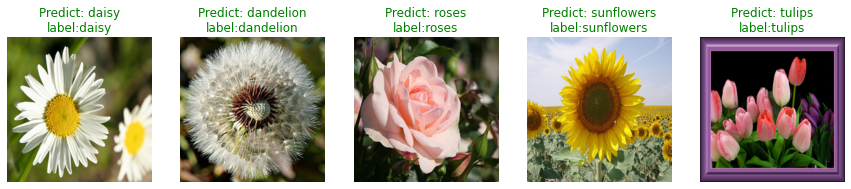

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mindvision.classification.models import resnet50
import mindspore as ms

def visualize_model(image_path, label):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((224, 224))
    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)

    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))

    # 扩展数据维数为(1, c, h, w)
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = network
    param_dict = ms.load_checkpoint("./checkpoints/best.ckpt")
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)

    # 模型预测
    pre = model.predict(ms.Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "daisy", 1: "dandelion", 2: "roses", 3: "sunflowers", 4: "tulips"}
    color = 'green' if class_name[result] == label else 'red'

    plt.title(f"Predict: {class_name[result]}\nlabel:{label}", color=color)
    plt.axis("off")
    return result

image1 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/daisy.jpg"
plt.figure(figsize=(15, 7))
plt.subplot(1, 5, 1)
visualize_model(image1, "daisy")

image2 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/dandelion.jpg"
plt.subplot(1, 5, 2)
visualize_model(image2, "dandelion")

image3 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/roses.jpg"
plt.subplot(1, 5, 3)
visualize_model(image3, "roses")

image4 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/sunflowers.jpg"
plt.subplot(1, 5, 4)
visualize_model(image4, "sunflowers")

image5 = "./dataset/case11Fiveflowers/case11/FiveFlowers/infer/tulips.jpg"
plt.subplot(1, 5, 5)
visualize_model(image5, "tulips")

plt.show()

### 2.7 模型导出

在模型训练完后，训练完成后的网络模型（即CKPT文件）转换为MindIR格式，用于后续手机侧的推理。通过`export`接口会在当前目录下会生成`resnet50.mindir`文件。

In [9]:
import mindspore as ms
import numpy as np

# 定义并加载网络参数
net = resnet50(num_classes=5)
param_dict = ms.load_checkpoint("./checkpoints/best.ckpt")
ms.load_param_into_net(net, param_dict)

# 将模型由ckpt格式导出为MINDIR格式
input_np = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
ms.export(net, ms.Tensor(input_np), file_name="./mindir/resnet50", file_format="MINDIR")

## 3. 手机侧推理与部署

为实现模型文件在手机侧的推理功能，步骤如下：

+ 转换文件格式：将MindIR文件格式，转换成Android手机上MindSpore Lite可识别的ms模型文件；

+ 应用部署：在手机侧部署应用APK，即下载一个MindSpore Vision套件Android APK；

+ 应用体验：最后将ms模型文件导入到手机侧后，体验花分类的识别功能。

### 3.1 转换文件格式

使用端侧应用的转换工具[MindSpore Lite Converter](https://www.mindspore.cn/lite/docs/zh-CN/r1.8/use/converter_tool.html)，将训练过程当中生成的resnet50.mindir文件，转换为MindSpore Lite端侧推理框架可识别的文件格式resnet50.ms文件。

#### 3.1.1 下载转换工具

这里提供Linux和Windows两种操作系统下转换工具MindSpore Lite Converter的下载链接:

+ [Linux-x86_64工具下载链接](https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.8.1/MindSpore/lite/release/linux/x86_64/mindspore-lite-1.8.1-linux-x64.tar.gz)

+ [Linux-aarch64工具下载链接](https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.8.1/MindSpore/lite/release/linux/aarch64/mindspore-lite-1.8.1-linux-aarch64.tar.gz)

+ [Windows-x64工具下载链接](https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.8.1/MindSpore/lite/release/windows/mindspore-lite-1.8.1-win-x64.zip)

运行下面代码下载转换工具。

> + linux系统可以打开终端（terminal），输入`uname -m`查看硬件架构；
>
> + windows系统可以打开命令提示符（cmd），输入`systeminfo`查看硬件架构；
>
> + 其他环境下载MindSpore Lite Converter参见[下载MindSpore Lite](https://www.mindspore.cn/lite/docs/zh-CN/r1.8/use/downloads.html)。

In [10]:
from mindvision.dataset import DownLoad
import os

def download(os="windows"):

    dataset_url_win = "https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.8.1/MindSpore/lite/release/windows/mindspore-lite-1.8.1-win-x64.zip"
    dataset_url_linux_x86_64 = "https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.8.1/MindSpore/lite/release/linux/x86_64/mindspore-lite-1.8.1-linux-x64.tar.gz"
    dataset_url_linux_aarch64 = "https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.8.1/MindSpore/lite/release/linux/aarch64/mindspore-lite-1.8.1-linux-aarch64.tar.gz"
    dataset_url_ascend = "https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.8.1/MindSpore/lite/release/linux/x86_64/ascend/mindspore-lite-1.8.1-linux-x64.tar.gz"
    # 根据操作系统选择相应的下载链接
    if os in ("windows", "Windows", "win"):
        dataset_url = dataset_url_win
    elif os in ("linux_x86_64", "Linux_x86_64"):
        dataset_url = dataset_url_linux_x86_64
    elif os in ("linux_aarch64", "Linux_aarch64"):
        dataset_url = dataset_url_linux_aarch64
    elif os in ("ascend", "Ascend"):
        dataset_url = dataset_url_ascend
    else:
        print("下载失败！不支持\"{}\"操作系统，请输入\"windows\"或者\"linux_x86_64\"或者\"linux_aarch64\"或者\"ascned\"".format(os))
        return

    path = "./"

    dl = DownLoad()
    # 下载并解压，默认选择windows系统的下载链接
    dl.download_and_extract_archive(dataset_url, path)
    print("下载成功!")

# 选择下列某一个代码取消注释，如windows系统用download("windows")下载
# download("windows")
# download("linux_x86_64")
download("linux_aarch64")
# download("ascend")

43300864B [00:18, 2376340.76B/s]                               


下载成功!


+ 创建ms文件夹用于存放.ms文件

In [11]:
import os

def mkdir(path):
    folder = os.path.exists(path)
    if not folder:
        os.makedirs(path)
        print('文件夹创建成功：', path)
    else:
        print('文件夹已经存在：', path)

file = r".\ms"
mkdir(file)

文件夹创建成功： .\ms


#### 3.1.2 执行文件转换

具体的模型文件格式转换方式如下所示：

1. Linux下使用MindSpore Lite Converter转换文件格式。

```shell
# 下载解压后设置软件包的路径，将converter_path替换为解压后工具包的路径，PACKAGE_ROOT_PATH为设置的环境变量
export PACKAGE_ROOT_PATH=converter_path

# 将转换工具需要的动态链接库加入到环境变量LD_LIBRARY_PATH
export LD_LIBRARY_PATH=${PACKAGE_ROOT_PATH}/tools/converter/lib:${LD_LIBRARY_PATH}

# 将转换工具需要的头文件加入到环境变量LD_INCLUDE_PATH
export LD_INCLUDE_PATH=${PACKAGE_ROOT_PATH}/tools/converter/include:${LD_INCLUDE_PATH}

# 在mindspore-lite-linux-x64/tools/converter/converter执行转换命令
# 本实验是/home/ma-user/work/mindspore-lite-1.8.1-linux-aarch64/tools/converter/converter
./converter_lite --fmk=MINDIR --modelFile=../../../../mindir/resnet50.mindir  --outputFile=../../../../ms/resnet50
```

2. Windows下使用MindSpore Lite Converter转换文件格式。

```shell
# 下载解压后设置软件包的路径，将converter_path替换为解压后工具包的路径，PACKAGE_ROOT_PATH为设置的环境变量
set PACKAGE_ROOT_PATH=converter_path

# 将转换工具exe文件加入到环境变量PATH
set PATH=%PACKAGE_ROOT_PATH%\tools\converter\converter\converter_lite.exe;%PATH%

# 将转换工具需要的头文件加入到环境变量PATH
set PATH=%PACKAGE_ROOT_PATH%\tools\converter\include;%PATH%

# 将转换工具需要的动态链接库加入到环境变量PATH
set PATH=%PACKAGE_ROOT_PATH%\tools\converter\lib;%PATH%

# 在mindspore-lite-win-x64\tools\converter\converter路径下执行转换命令
call converter_lite --fmk=MINDIR --modelFile=../../../../mindir/resnet50.mindir --outputFile=../../../../ms/resnet50
```

转换成功后打印`CONVERT RESULT SUCCESS:0`，且在当前目录下生成`resnet50.ms`文件。

## 4. 应用部署与体验

### 4.1 应用部署

下载MindSpore Vision套件的[Android端应用APK](https://download.mindspore.cn/vision/android/mindvision-0.1.0.apk)，或者手机扫描二维码下载。

![qr](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/source_zh_cn/beginner/images/app_qr_code.png)

并在手机上安装该APK，其应用名称显示为`MindSpore Vision`。

> MindSpore Vision APK主要是作为视觉开发工具的示例所用，提供拍照、选择图片等基础UI功能，并且提供分类、检测等AI应用DEMO。

打开APP后，在首页点击`分类`模块后，即可点击中间按钮进行拍照获取图片，或者点击上侧栏的图像按钮选择进行图片相册用于图像分类功能。

![main](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/source_zh_cn/beginner/images/app1.png)

在默认情况下，MindSpore Vision`分类`模块内置了一个通用的AI网络模型对图像进行识别分类。

![result](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/source_zh_cn/beginner/images/app2.png)

### 4.2 应用体验

最后将上述训练的自定义网络模型resnet50.ms或者量化后的模型resnet50_quant.ms部署到Android手机侧，体验花分类的识别功能。

#### 4.2.1 自定义模型标签文件

自定义模型部署需要按照如下格式定义网络模型需要用到的信息，即自定义标签文件，并在本地电脑端侧创建一个必须以`custom.json`命名的json格式标签文件。

```text
{
    "title": '图像分类',
    "file": 'resnet50.ms',
    "label": ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
}
```

Json标签文件中需包含`title`，`file`，`label`三个Key值字段，其含义如下：

+ title ：自定义模块标题(花分类)；

+ file ：上文转换好的模型文件名称；

+ label ：自定义标签label的`数组`信息。

#### 4.2.2 标签与模型文件部署到手机

在`MindSpore Vision APK`的首页上长按`分类`按钮，可以进入自定义分类模式，并且选择需要部署的标签和模型文件。

为实现手机端花分类的识别功能，需将标签文件`custom.json`文件和模型文件`resnet50.ms`一起放置到手机上指定目录下。这里以`Android/data/Download/` 文件夹为例，首先把标签文件和模型文件同时放在上述手机地址，如图所示，点击自定义按钮，然后会弹出系统文件功能，点击左上角的打开文件，然后找到Json标签文件和模型文件存放的目录地址，并选择对应的Json文件。

![step](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r1.8/tutorials/source_zh_cn/beginner/images/app3.png)

标签与模型文件部署到手机后，即可点击中间按钮进行拍照获取图片，或者点击上侧栏的图像按钮选择图片相册用于图像，就可以进行花分类的分类识别。

<div align="center">
<img src="./images/app4.jpg" width="40%" height="40%" />
</div>

> 本实验仅包含手机侧简单的部署过程，想要了解推理更多内容请参考[MindSpore Lite](https://www.mindspore.cn/lite/docs/zh-CN/r1.8/index.html)。


## 5. 实验任务

训练一个自定义的分类模型，提供“梅兰竹菊”四君子数据集与“狗和牛角包”数据集，根据实验内容，获得自己的微调好的模型并部署到手机端。